<a href="https://colab.research.google.com/github/rhamdansyahrulm/EV-Battery-Charge-Optimization-with-Fuzzy-Logic-and-Neural-Network/blob/main/Machine_learning/modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Preparing**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install scikit-fuzzy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 994.0/994.0 kB 17.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-py3-none-any.whl size=894073 sha256=a1c50cda1960e8c774b83dfe1eeb97d29712973fd28a33336dee4e697a98140f
  Stored in directory: /root/.cache/pip/wheels/4f/86/1b/dfd97134a2c8313e519bcebd95d3fedc7be7944db022094bc8
Successfully built scikit-fuzzy


In [ ]:
## Import library
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import shapiro
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.stats.mstats import winsorize, trim
from sklearn.model_selection import train_test_split
import skfuzzy as fuzz
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.models import load_model
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

sns.set(style="whitegrid")
warnings.filterwarnings('ignore', message="X does not have valid feature names")

# **Exploratory Data Analysis (EDA)**

In [ ]:
# Read the Excel data into a pandas DataFrame.
loc_data = "/content/drive/MyDrive/Tugas Akhir/export_data2_lama.xlsx"
data = pd.read_excel(loc_data)

# Drop the 'avgSOC' and 'avgSuhu' columns from the DataFrame.
data.drop(["avgSOC", "avgSuhu"], axis=1, inplace=True)

# Display the first few rows of the preprocessed data.
data.head()

,suhuRuangan,suhuAwalBaterai,t1,t2,t3,t4,lastSOC,lastSuhu
0,303.193929,298.806720,1989.837053,2484.470510,2542.123990,2576.319007,0.851020,317.309458
1,300.558673,302.711118,2423.812138,2577.484071,2579.005641,2579.668628,0.882221,310.028390
2,304.110812,303.272620,1146.955383,1646.355556,1827.806809,2462.600050,0.784630,310.973665
3,303.561977,301.752974,1525.864771,1599.123329,2090.767144,2162.373749,0.812371,311.069649
4,303.933663,300.188227,977.111096,2315.797019,2481.928992,2521.499903,0.776907,311.689400
...,...,...,...,...,...,...,...,...
144,298.443243,304.365421,525.897015,768.162257,1865.250538,1960.139276,0.627971,306.412168
145,300.440794,298.864207,1161.106690,1790.237228,1919.427975,1930.514694,0.793491,314.155536
146,299.044868,301.675466,1469.393813,2207.633177,2383.932937,2522.682927,0.807579,308.521139
147,300.581021,299.783450,2274.252663,2386.396835,2536.595380,2548.339416,0.871663,311.536997


In [ ]:
# Generate and display descriptive statistics for the dataset.
data.describe()

,suhuRuangan,suhuAwalBaterai,t1,t2,t3,t4,lastSOC,lastSuhu
count,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000,149.000000
mean,301.731504,301.463287,1299.993789,1925.768515,2250.530907,2413.072766,0.777776,310.797727
std,2.041885,2.056483,756.659631,566.784836,354.961697,218.937848,0.089968,3.444972
min,298.208926,298.180731,0.884502,197.659316,916.870654,1720.887818,0.486644,304.477197
25%,300.003533,299.447609,646.566857,1571.056118,2096.070828,2366.605951,0.720579,308.804064
50%,301.835144,301.341862,1257.439919,2062.998409,2390.852911,2517.730218,0.798010,310.614289
75%,303.402814,303.298387,1921.611293,2392.624349,2526.691712,2561.675237,0.843838,311.817914
max,305.053676,305.061511,2573.140664,2579.472551,2579.555235,2579.763716,0.894346,324.716607


In [ ]:
# Compute and display the correlation matrix for the remaining columns.
data.corr()

,suhuRuangan,suhuAwalBaterai,t1,t2,t3,t4,lastSOC,lastSuhu
suhuRuangan,1.000000,0.115596,0.081631,0.129624,0.135283,0.084271,0.124045,0.307521
suhuAwalBaterai,0.115596,1.000000,0.121024,0.047284,0.023175,-0.018084,0.053022,-0.409602
t1,0.081631,0.121024,1.000000,0.608939,0.443700,0.378228,0.914663,0.445005
t2,0.129624,0.047284,0.608939,1.000000,0.695718,0.537589,0.766359,0.308006
t3,0.135283,0.023175,0.443700,0.695718,1.000000,0.734088,0.506589,0.168178
t4,0.084271,-0.018084,0.378228,0.537589,0.734088,1.000000,0.403720,0.120216
lastSOC,0.124045,0.053022,0.914663,0.766359,0.506589,0.403720,1.000000,0.542211
lastSuhu,0.307521,-0.409602,0.445005,0.308006,0.168178,0.120216,0.542211,1.000000


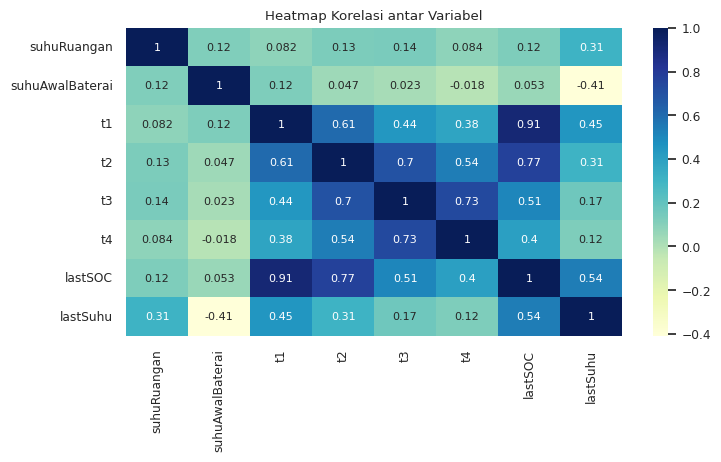

In [ ]:
"""
Create a heatmap to visualize the correlation between variables in the dataset.
This code generates a heatmap that visually represents the correlation between different variables in the dataset.
The colors and annotations in the heatmap help in understanding the strength and direction of relationships between variables.
The title "Heatmap Korelasi antar Variabel" indicates the purpose of the visualization.
"""

plt.figure(figsize=(8, 4)) # Set the figure size.
sns.set(font_scale=0.8) # Set the font scale for readability.
sns.heatmap(data.corr(), cmap="YlGnBu", annot=True, annot_kws={"size": 8})
plt.title("Correlation Heatmap between Variables")
plt.show()

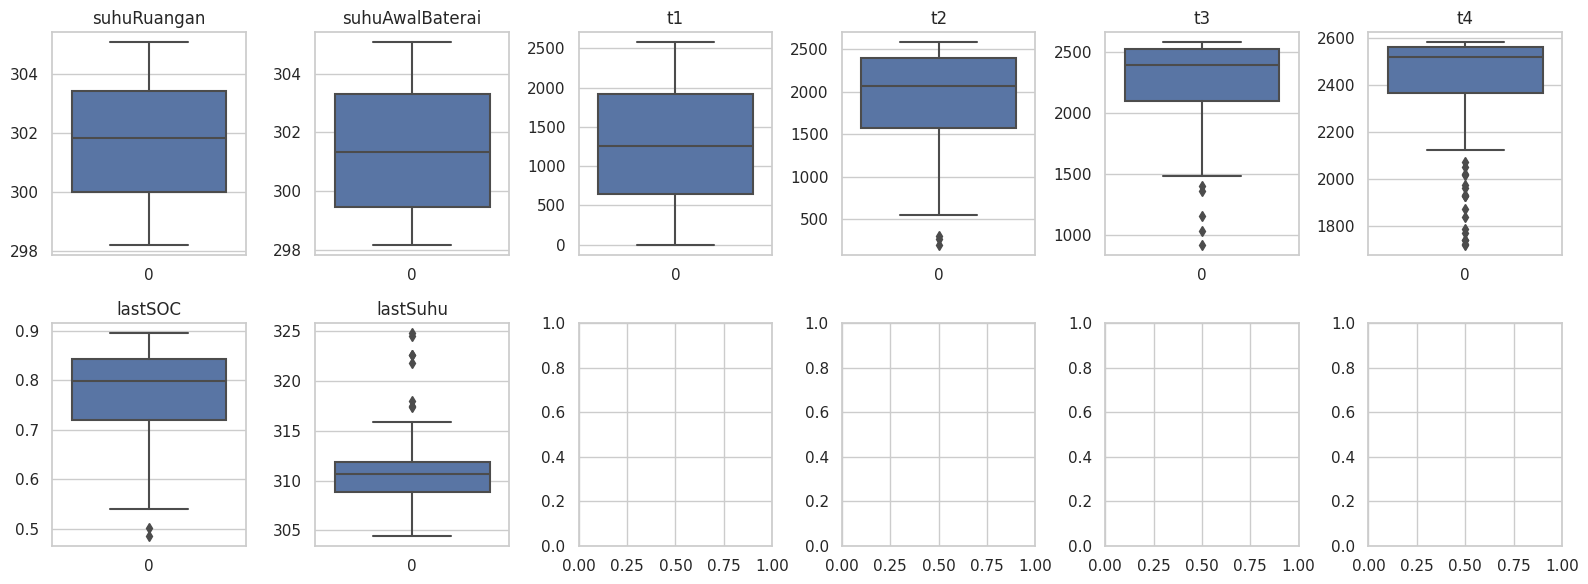

In [ ]:
"""
Create subplots to display box plots for each variable in the dataset.
# This code generates subplots to display box plots for each variable in the dataset.
It provides a visual summary of the distribution and potential outliers for each variable.
The title of each subplot corresponds to the variable name.
"""

# Iterate through each column in the dataset and create a box plot.
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(16, 6))
for col, ax in zip(data.columns, axes.flatten()):
    sns.boxplot(data=data[col], ax=ax)
    ax.set(title=f'{col}')
plt.tight_layout()
plt.show()

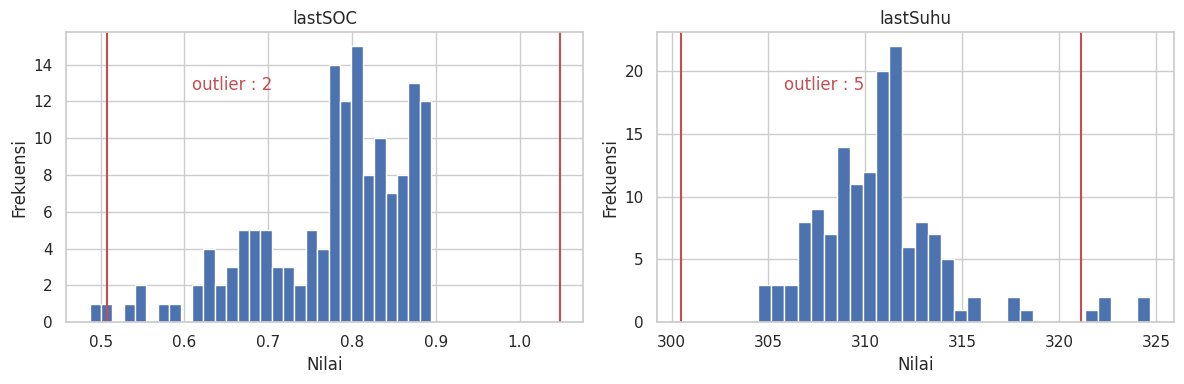

In [ ]:
"""
Create two subplots to display histograms and detect outliers for specific columns.
This code creates two subplots: one for 'lastSOC' and another for 'lastSuhu'.
It calculates the outlier limits based on three times the standard deviation and marks them with red vertical lines
on the histograms. The number of outliers is displayed on each subplot.
"""

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Specify the columns of interest.
columns = ["lastSOC", "lastSuhu"]
limits = []

# Loop through the columns to calculate outlier limits and create histograms.
for i, column in enumerate(columns):
    mean = data[column].mean()
    std = data[column].std()
    limit = 3 * std
    limit_upper = mean + limit
    limit_lower = mean - limit
    limits.append((limit_upper, limit_lower))

    ax = (ax1, ax2)[i]

    # Create a histogram for the column.
    ax.hist(data[column], bins=30)

    # Add vertical lines to indicate the outlier limits.
    ax.axvline(limit_upper, color='r')
    ax.axvline(limit_lower, color='r')
    ax.set_title(column)
    ax.set_xlabel('Nilai')
    ax.set_ylabel('Frekuensi')

    # Detect and display the number of outliers.
    outliers = data[(data[column] > limit_upper) | (data[column] < limit_lower)]
    num_outliers = len(outliers)
    ax.text(0.4, 0.85, f"outlier : {num_outliers}", transform=ax.transAxes,
            verticalalignment='top', horizontalalignment='right', color='r')

plt.tight_layout()
plt.show()

In [ ]:
"""
This code calculates the outlier limits for 'lastSOC' and 'lastSuhu', identifies and stores outliers,
and creates a new DataFrame 'data_no_outlier' that contains data points without outliers.
The final DataFrame is displayed with a message indicating that outliers have been removed.
"""

# Define the columns of interest.
columns = ["lastSOC", "lastSuhu"]
limits = []

# Loop through the columns to calculate outlier limits and remove outliers.
for column in columns:
    mean = data[column].mean()
    std = data[column].std()
    limit = 3 * std
    limit_upper = mean + limit
    limit_lower = mean - limit
    limits.append((limit_upper, limit_lower))

    outliers = data[(data[column] > limit_upper) | (data[column] < limit_lower)]
    data_no_outlier = data[(data[column] <= limit_upper) & (data[column] >= limit_lower)]

print("Data setelah menghapus outlier:")
data_no_outlier

Data setelah menghapus outlier:


,suhuRuangan,suhuAwalBaterai,t1,t2,t3,t4,lastSOC,lastSuhu
0,303.193929,298.806720,1989.837053,2484.470510,2542.123990,2576.319007,0.851020,317.309458
1,300.558673,302.711118,2423.812138,2577.484071,2579.005641,2579.668628,0.882221,310.028390
2,304.110812,303.272620,1146.955383,1646.355556,1827.806809,2462.600050,0.784630,310.973665
3,303.561977,301.752974,1525.864771,1599.123329,2090.767144,2162.373749,0.812371,311.069649
4,303.933663,300.188227,977.111096,2315.797019,2481.928992,2521.499903,0.776907,311.689400
...,...,...,...,...,...,...,...,...
144,298.443243,304.365421,525.897015,768.162257,1865.250538,1960.139276,0.627971,306.412168
145,300.440794,298.864207,1161.106690,1790.237228,1919.427975,1930.514694,0.793491,314.155536
146,299.044868,301.675466,1469.393813,2207.633177,2383.932937,2522.682927,0.807579,308.521139
147,300.581021,299.783450,2274.252663,2386.396835,2536.595380,2548.339416,0.871663,311.536997


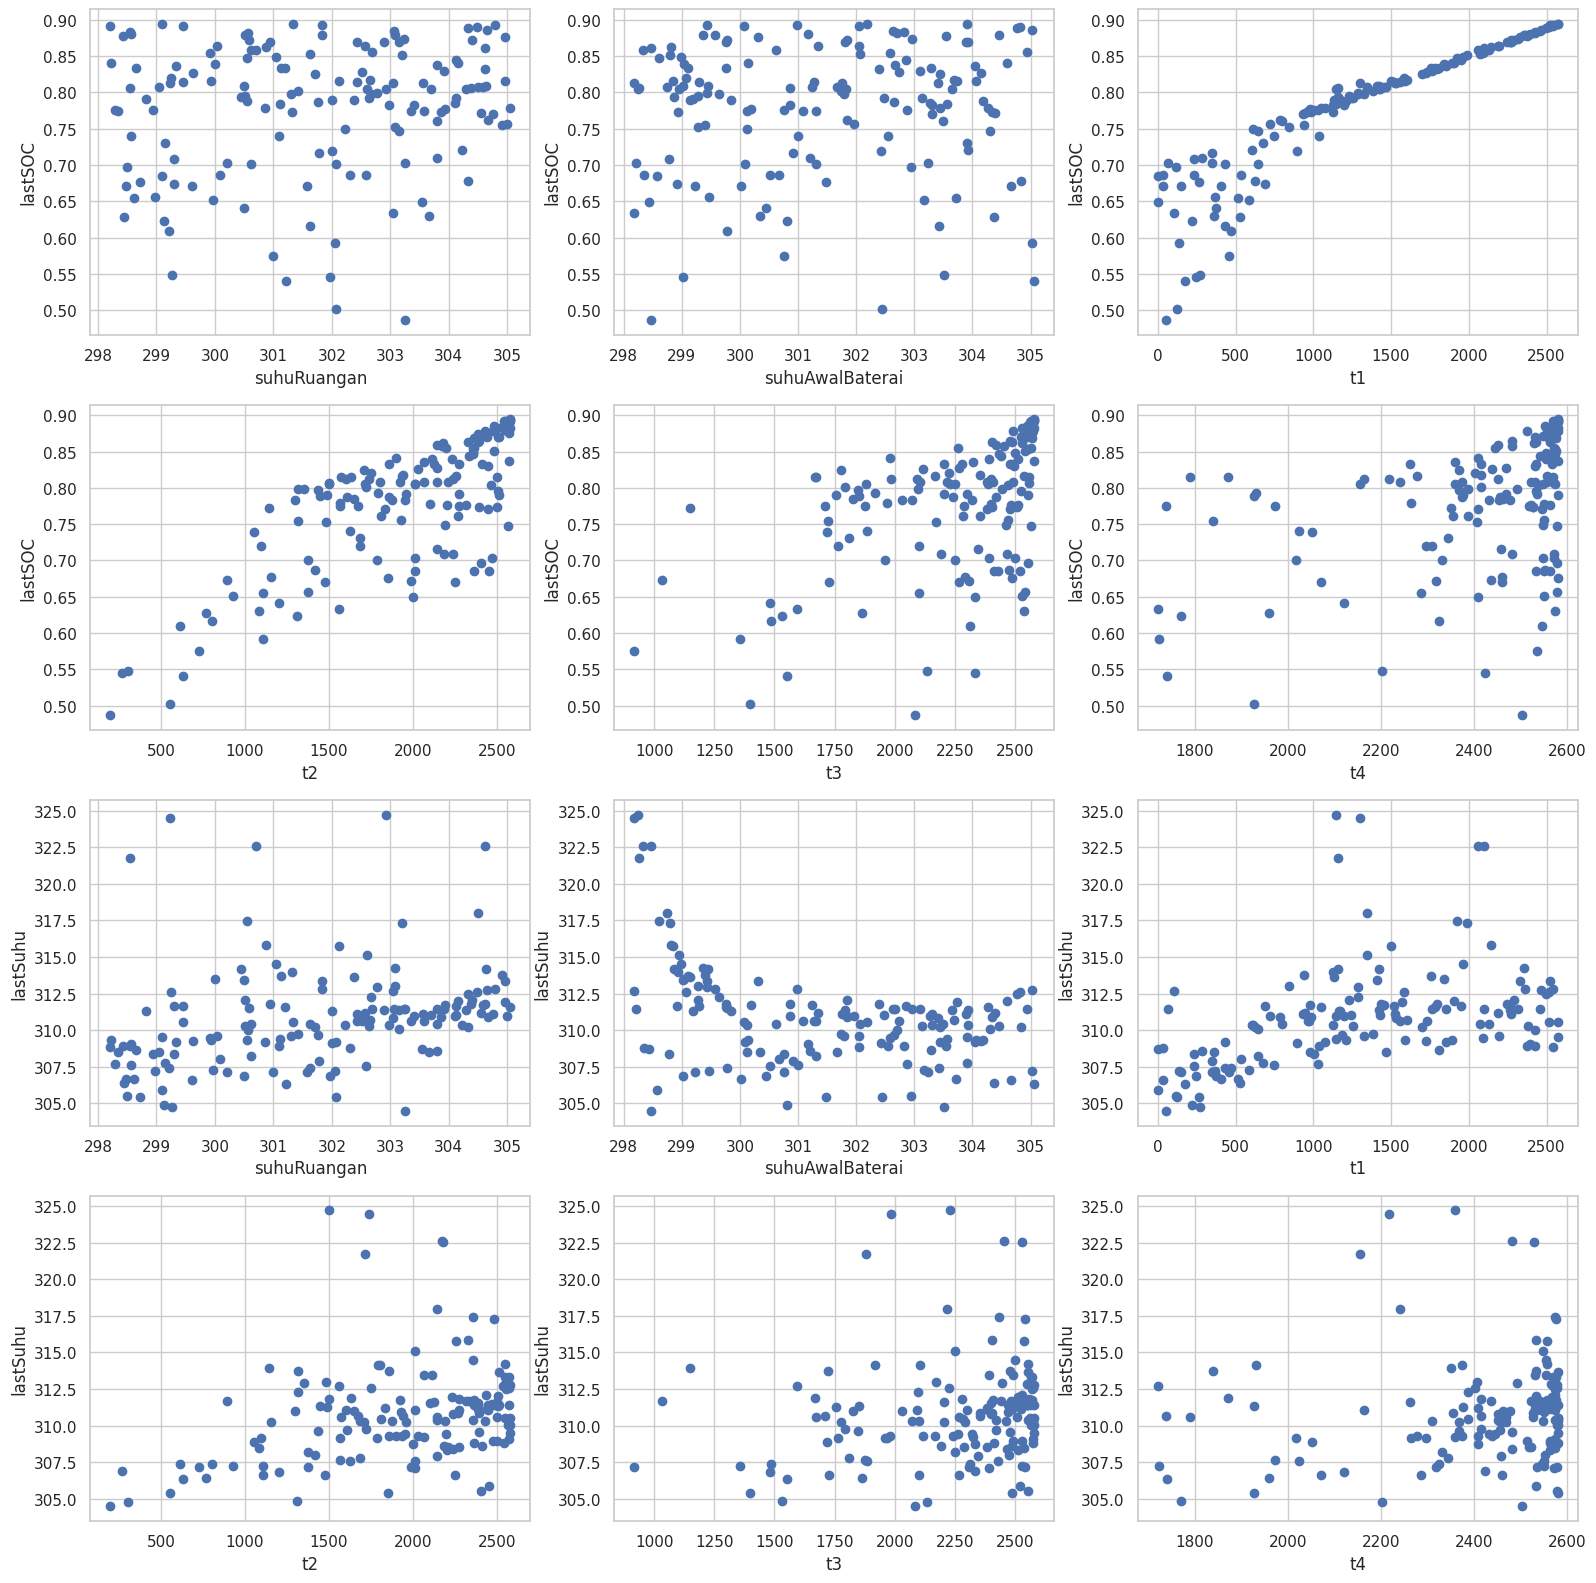

In [ ]:
"""
This code retrieves column names for the x-axis, creates subplots for scatter plots,
and visualizes the relationships between different features and the target variables "lastSOC" and "lastSuhu".
The resulting figure provides insights into how each feature correlates with the target variables.
"""

# Get column names for the x-axis
x_col = data.iloc[:,:-2].columns
n_cols = len(x_col)

# Create subplot graphics
fig, axs = plt.subplots(nrows=4, ncols=3, figsize=(16, 16))

# Create scatter plots for the target variable "lastSOC"
for i, ax in enumerate(axs[0]):
    ax.scatter(data[x_col[i]], data['lastSOC'])
    ax.set_xlabel(x_col[i])
    ax.set_ylabel('lastSOC')

for i, ax in enumerate(axs[1]):
    ax.scatter(data[x_col[i+3]], data['lastSOC'])
    ax.set_xlabel(x_col[i+3])
    ax.set_ylabel('lastSOC')

# Create scatter plots for the target variable "lastSuhu"
for i, ax in enumerate(axs[2]):
    ax.scatter(data[x_col[i]], data['lastSuhu'])
    ax.set_xlabel(x_col[i])
    ax.set_ylabel('lastSuhu')

for i, ax in enumerate(axs[3]):
    ax.scatter(data[x_col[i+3]], data['lastSuhu'])
    ax.set_xlabel(x_col[i+3])
    ax.set_ylabel('lastSuhu')

# Display the figure
plt.tight_layout()
plt.show()

In [ ]:
"""
This code performs standardization on the dataset using Min-Max scaling, resulting in a DataFrame 'data_std'
with standardized values. It scales the data so that all values are within the range [0, 1].
"""

# Standardization
scaler = MinMaxScaler() # Create a MinMaxScaler instance
data_std = scaler.fit_transform(data) # Standardize the data

# Convert the standardized array to a DataFrame
data_std = pd.DataFrame(data_std, columns=data.columns)

# Check the results
data_std.head()

,suhuRuangan,suhuAwalBaterai,t1,t2,t3,t4,lastSOC,lastSuhu
0,0.728296,0.090976,0.773233,0.960114,0.977487,0.995989,0.893731,0.634023
1,0.343292,0.658412,0.941946,0.999165,0.999669,0.999889,0.970259,0.274276
2,0.862250,0.740016,0.445551,0.608233,0.547871,0.863585,0.730891,0.320981
3,0.782067,0.519162,0.592857,0.588402,0.706025,0.514028,0.798935,0.325724
4,0.836369,0.291754,0.379522,0.889296,0.941284,0.932163,0.711949,0.356344


# **Machine Learning Modelling**

## **Neural Network**

In [ ]:
"""
Split the data into training and testing sets for features (x) and target variables (y).
It then prints the dimensions of these sets for reference.
"""

x = data_std.iloc[:, 0:6]
y = data_std.iloc[:, 6:8]

x_train, x_test, y_train, y_test = train_test_split(x,
                                                    y,
                                                    train_size=0.8,
                                                    random_state=1)

print(f"""
--Dimensi Data--
X train : {x_train.shape}
X test : {x_test.shape}
y train : {y_train.shape}
y test : {x_test.shape}
""")


--Dimensi Data--
X train : (119, 6)
X test : (30, 6)
y train : (119, 2)
y test : (30, 6)



In [ ]:
"""
This code defines a sequential neural network model with multiple dense layers, each using the ReLU activation function.
It compiles the model with the Adam optimizer and mean squared error as the loss function. The model architecture is displayed,
and it is trained on the training data for 500 epochs with a validation split of 20%.
"""

# Create a sequential neural network model
model = Sequential()
model.add(Dense(32, input_dim=6, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='relu'))
model.compile(optimizer='adam', loss='mean_squared_error')

# Display and train the model architecture
model.summary()
history = model.fit(x_train, y_train, epochs=500, validation_split=0.2)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                224       
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 128)               8320      
                                                                 
 dense_3 (Dense)             (None, 64)                8256      
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 2)                 66        
                                                                 
Total params: 21,058
Trainable params: 21,058
Non-traina

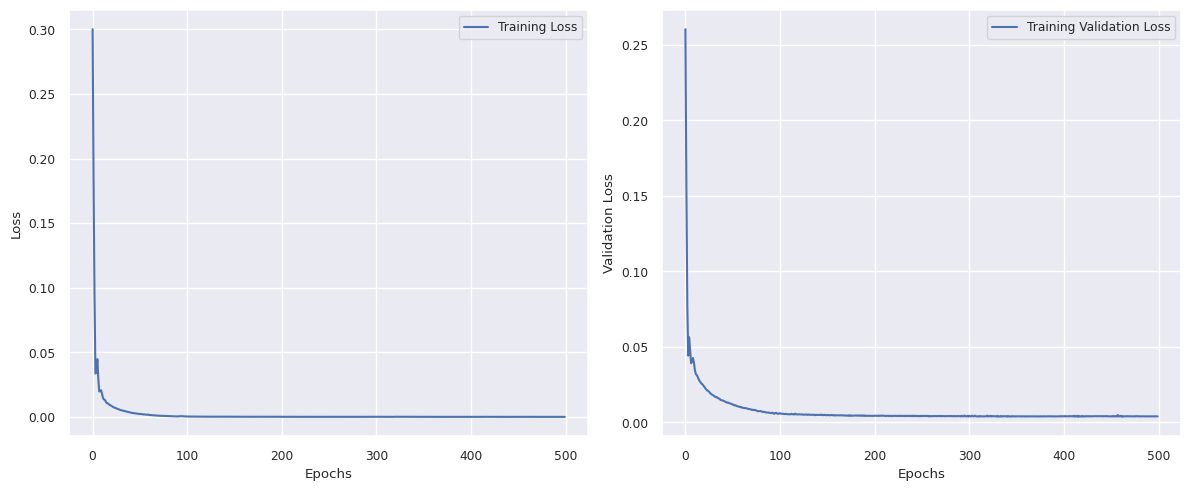

In [ ]:
def plot_evaluation(history):
    # Retrieve the evaluation metrics from the history object
    accuracy = history.history['loss']
    loss = history.history['val_loss']

    # Create subplots for accuracy and loss
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Plot accuracy
    ax1.plot(accuracy, label='Training Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot loss
    ax2.plot(loss, label='Training Validation Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Validation Loss')
    ax2.legend()

    # Show the plot
    plt.tight_layout()
    plt.show()

plot_evaluation(history)

In [ ]:
"""
This function evaluates a model's performance on a test dataset. It takes the model, test data (x_test),
the scaler used for standardization, and the original dataset (data).
It makes predictions using the model, transforms the predictions back to their original scale,
and calculates absolute errors for both "predictSOC" and "predictSuhu" compared to the original values.
"""

def testing_model(model, x_test, scaler, data):
    data = data.iloc[:, -2:][data.index.isin(x_test.index)]
    x_test = x_test.sort_index()
    y_pred = model.predict(x_test) # Make predictions using the model
    y_pred_df = pd.DataFrame(y_pred, columns=['predictSOC', 'predictSuhu']) # Create a DataFrame from the predictions
    predict = pd.concat([x_test.reset_index(drop=True), y_pred_df], axis=1) # Combine the test data with the predictions

    original_pred = pd.DataFrame(scaler.inverse_transform(predict), columns=predict.columns)
    comparison_result = pd.concat([original_pred, data.reset_index(drop=True)], axis=1)
    comparison_result["absoluteErrorSOC"] = np.absolute(comparison_result["predictSOC"] - comparison_result["lastSOC"])
    comparison_result["absoluteErrorSuhu"] = np.absolute(comparison_result["predictSuhu"] - comparison_result["lastSuhu"])

    return comparison_result

In [ ]:
result_testing = testing_model(model, x_test, scaler, data)
result_testing.head(10)

1/1 [==============================] - 0s 102ms/step


,suhuRuangan,suhuAwalBaterai,t1,t2,t3,t4,predictSOC,predictSuhu,lastSOC,lastSuhu,absoluteErrorSOC,absoluteErrorSuhu
0,302.770011,299.432214,1284.865473,1352.161568,2448.047312,2491.659335,0.802988,317.216915,0.798537,312.921291,0.004451,4.295624
1,298.343872,300.126582,978.690569,2272.743480,2287.912123,2517.730218,0.774457,309.033212,0.774958,308.526057,0.000501,0.507155
2,302.516452,302.728853,1733.090243,2144.286039,2268.575968,2468.211229,0.826141,310.544368,0.827500,310.614289,0.001359,0.069921
3,298.572225,301.164239,2396.479424,2572.933585,2573.386672,2574.059878,0.875527,309.249825,0.880459,309.086450,0.004932,0.163375
4,300.989794,300.762765,458.201671,723.975854,916.870654,2533.825752,0.600606,305.596231,0.574789,307.145795,0.025817,1.549564
5,301.830613,299.568375,2363.998007,2549.452395,2550.977484,2564.017110,0.877069,312.671104,0.879269,312.845226,0.002200,0.174122
6,301.134946,299.109942,1760.021097,1858.004060,2478.449624,2533.649108,0.828320,315.063404,0.833055,313.733710,0.004735,1.329694
7,304.481835,304.815759,2515.333236,2573.797184,2575.694103,2578.284587,0.889793,312.488773,0.889315,312.597609,0.000478,0.108836
8,299.965125,303.168006,584.145704,929.147400,2528.135619,2548.871001,0.656492,306.024760,0.651656,307.270442,0.004836,1.245682
9,304.546112,304.393265,949.225789,1831.912760,2384.926888,2407.276168,0.775965,311.312189,0.771380,311.197226,0.004585,0.114963


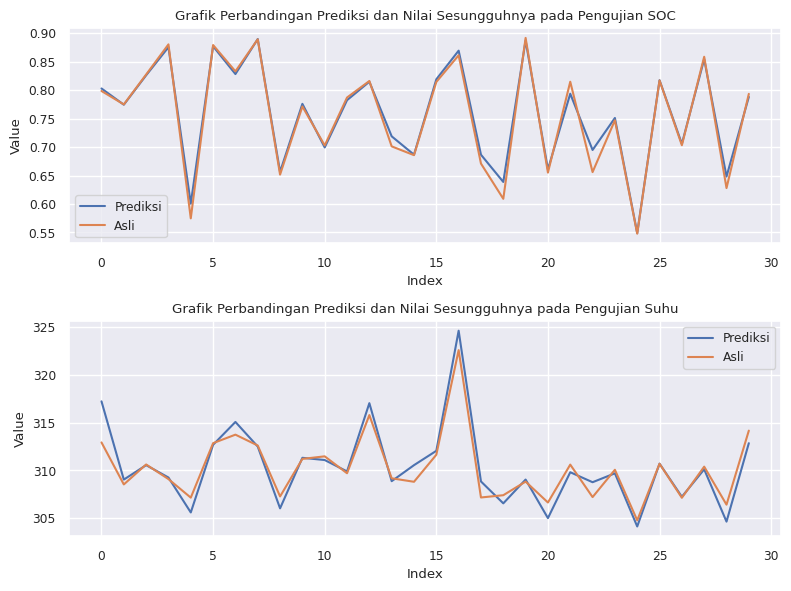

In [ ]:
# Create subplots with two graphs in one column (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))

# Graph for predictSOC and lastSOC
ax1.plot(result_testing.index, result_testing['predictSOC'], label='Prediksi')
ax1.plot(result_testing.index, result_testing['lastSOC'], label='Asli')
ax1.set_xlabel('Index')
ax1.set_ylabel('Value')
ax1.set_title('Grafik Perbandingan Prediksi dan Nilai Sesungguhnya pada Pengujian SOC')
ax1.legend()

# Graph for predictSuhu and lastSuhu
ax2.plot(result_testing.index, result_testing['predictSuhu'], label='Prediksi')
ax2.plot(result_testing.index, result_testing['lastSuhu'], label='Asli')
ax2.set_xlabel('Index')
ax2.set_ylabel('Value')
ax2.set_title('Grafik Perbandingan Prediksi dan Nilai Sesungguhnya pada Pengujian Suhu')
ax2.legend()

# Display the graphs
plt.tight_layout()
plt.show()

In [ ]:
# Extract the minimum values from columns "t1," "t2," "t3," and "t4"
t1_check, t2_check, t3_check, t4_check = [data[data[col] == data[col].min()][col].values[0] for col in ["t1", "t2", "t3", "t4"]]

# Create a DataFrame for input values for suhuRuangan and suhuAwalBaterai
finding = pd.DataFrame({
    'suhuRuangan'     : [float(input("Suhu Lingkungan Saat ini ? \n"))] * 100000,
    'suhuAwalBaterai' : [float(input("Suhu permukaan baterai saat ini ? \n"))] * 100000
})


params = []
columns_name = ["t1"," t2", "t3", "t4"]

# Generate parameter combinations until 100,000 combinations are achieved
while len(params) != 100000:
    # Generate random values for t1, t2, t3, and t4 within specified ranges
    t1 = random.random() * (2580 - 0)
    t2 = t1 + random.random() * (2580 - t1)
    t3 = t2 + random.random() * (2580 - t2)
    t4 = t3 + random.random() * (2580 - t3)

    # Check if the generated values meet certain conditions
    if t1 >=  t1_check and t2 >=  t2_check and t3 >=  t3_check and t4 >=  t4_check:
      params.append([t1, t2, t3, t4])

# Concatenate the generated parameters to the 'finding' DataFrame
finding = pd.concat([finding, pd.DataFrame(params, columns=columns_name)], axis=1)

# Initialize columns "lastSOC" and "lastSuhu" with zeros
for target in ["lastSOC", "lastSuhu"]:
  finding[target] = 0

# Normalize the 'finding' DataFrame using the 'scaler' and create a new DataFrame 'norm_finding_df'
norm_finding = scaler.transform(np.array(finding))
norm_finding_df = pd.DataFrame(norm_finding, columns=finding.columns)

norm_finding_df.head()

Suhu Lingkungan Saat ini ? 
301.15
Suhu permukaan baterai saat ini ? 
302.15


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,suhuRuangan,suhuAwalBaterai,t1,t2,t3,t4,lastSOC,lastSuhu
0,0.429683,0.576863,0.993711,0.996297,0.998550,0.998233,-1.193628,-15.043778
1,0.429683,0.576863,0.993384,0.990980,0.994672,0.998208,-1.193628,-15.043778
2,0.429683,0.576863,0.237461,0.233133,0.386706,0.953540,-1.193628,-15.043778
3,0.429683,0.576863,0.096547,0.861016,0.806791,0.732636,-1.193628,-15.043778
4,0.429683,0.576863,0.287887,0.630331,0.883149,0.937799,-1.193628,-15.043778


In [ ]:
# Standardization
# Transform the 'finding' DataFrame using the 'scaler' to standardize the data
norm_finding = scaler.transform(np.array(finding))

# Create a new DataFrame 'norm_finding_df' with standardized data and original column names
norm_finding_df = pd.DataFrame(norm_finding, columns=finding.columns)

norm_finding_df.head()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


,suhuRuangan,suhuAwalBaterai,t1,t2,t3,t4,lastSOC,lastSuhu
0,0.429683,0.576863,0.231826,0.293469,0.872546,0.981832,-1.193628,-15.043778
1,0.429683,0.576863,0.561096,0.691696,0.628390,0.674223,-1.193628,-15.043778
2,0.429683,0.576863,0.001508,0.878716,0.944410,0.970043,-1.193628,-15.043778
3,0.429683,0.576863,0.937133,0.934741,0.968897,1.000066,-1.193628,-15.043778
4,0.429683,0.576863,0.993326,0.997558,0.998086,0.998628,-1.193628,-15.043778


In [ ]:
x_find = norm_finding_df.iloc[:, :-2] # Extract features (input data) from the standardized 'norm_finding_df' DataFrame
y_find = model.predict(x_find) # Use the trained model to predict target values based on the features

# Create a DataFrame 'norm_result' by combining the input features and predicted target values
norm_result = pd.DataFrame(data=np.concatenate((x_find.values, y_find), axis=1),
                           columns=list(x_find.columns) + ["soc", "temp"])

# Inverse transform the standardized 'norm_result' DataFrame to obtain the original scale of the data
result = pd.DataFrame(scaler.inverse_transform(norm_result), columns=norm_result.columns)
result.head()

3125/3125 [==============================] - 5s 2ms/step


,suhuRuangan,suhuAwalBaterai,t1,t2,t3,t4,soc,temp
0,304.333605,304.773983,303.764110,1459.022197,2253.182483,2330.337115,0.651865,309.264015
1,304.333605,304.773983,2578.202498,2578.695215,2579.240550,2579.956341,0.894259,312.512212
2,304.333605,304.773983,724.864102,1319.371024,1910.131244,2052.170870,0.714238,311.106673
3,304.333605,304.773983,305.958669,2457.961317,2525.458995,2554.057121,0.731782,309.041179
4,304.333605,304.773983,1531.215168,2339.273808,2554.171859,2562.534471,0.813300,311.622260


In [ ]:
# Destination folder path to save the model
folder_path = '/content/drive/MyDrive/Tugas Akhir/'

# Save the model to a .h5 file
model.save(folder_path + 'model_ta.h5')
print('Model successfully saved in the folder', folder_path)

Model berhasil disimpan di folder /content/drive/MyDrive/Tugas Akhir/


In [ ]:
def generate_finding(data, model, scaler, roomTemperature, initialBatteryTemperature, i, z_t):
    # Initialize variables for room temperature, initial battery temperature, and other parameters
    room_temperature = roomTemperature
    initial_battery_temperature = initialBatteryTemperature
    i_t = i
    z_t_s = z_t

    # Extract the minimum values of t1, t2, t3, and t4 from the data
    t1_check, t2_check, t3_check, t4_check = [data[data[col] == data[col].min()][col].values[0] for col in ["t1", "t2", "t3", "t4"]]

    # Initialize a list to store parameter combinations and column names
    params = []
    column_names = ["t1", "t2", "t3", "t4"]

    # Generate parameter combinations until 100,000 combinations are achieved
    while len(params) != 100000:
        # Generate random values for t1, t2, t3, and t4 within specified ranges or based on previous values
        t1 = 2000 + random.random() * (2580 - 2000) if len(z_t_s) == 0 else z_t_s[0]
        t2 = 2225 + random.random() * (2580-2225) if len(z_t_s) <= 1 else z_t_s[1]
        t3 = t2 + random.random() * (2580-t2) if len(z_t_s) <= 2 else z_t_s[2]
        t4 = t3 + random.random() * (2580-t3)

        # Check if the generated values meet certain conditions
        if t1 >= t1_check and t2 >= t2_check and t3 >= t3_check and t4 >= t4_check and t1 <= (2580*0.82) and t2 <= 2400:
            params.append([t1, t2, t3, t4])

    # Create a DataFrame 'finding' with room temperature, initial battery temperature, and generated parameters
    finding = pd.DataFrame({
        'roomTemperature': [room_temperature] * 100000,
        'initialBatteryTemperature': [initial_battery_temperature] * 100000
    })

    # Concatenate the generated parameters to the 'finding' DataFrame
    finding = pd.concat([finding, pd.DataFrame(params, columns=column_names)], axis=1)

    # Initialize columns for "lastSOC" and "lastTemperature" with zeros
    for target in ["lastSOC", "lastTemperature"]:
        finding[target] = 0

    # Normalize the 'finding' DataFrame using the 'scaler'
    norm_finding = scaler.transform(np.array(finding))
    norm_finding_df = pd.DataFrame(norm_finding, columns=finding.columns)

    # Extract input features from the normalized 'norm_finding_df'
    x_find = norm_finding_df.iloc[:, :-2]

    # Use the trained model to predict "soc" and "temperature" values based on input features
    y_find = model.predict(x_find, verbose=0)

    # Create a DataFrame 'norm_result' by combining input features and predicted values
    norm_result = pd.DataFrame(data=np.concatenate((x_find.values, y_find), axis=1),
                              columns=list(x_find.columns) + ["soc", "temperature"])

    # Inverse transform the standardized data to obtain the original scale of the data
    result = pd.DataFrame(scaler.inverse_transform(norm_result), columns=norm_result.columns)

    # Find the index with the minimum "temperature" value when "soc" is above 0.8
    min_temperature = result[result["soc"] >= 0.8]["temperature"].idxmin()

    # Find the index with the highest "soc" value
    high_soc = result["soc"].idxmax()

    # Create a summary DataFrame with "min_temperature" and "high_soc" values
    result_summary = pd.DataFrame({"min_temperature": result.loc[min_temperature],
                                  "high_soc": result.loc[high_soc]}).T

    return result_summary

## **Fuzzy Logic**

In [ ]:
# Extract the low and high state of charge (SOC) values from the result summary
low_soc = result_summary.loc["min_temp"]["soc"]
high_soc = result_summary.loc["high_soc"]["soc"]

# Extract the low and high temperature values from the result summary
low_temp = result_summary.loc["min_temp"]["temp"]
high_temp = result_summary.loc["high_soc"]["temp"]

# Extract the low and high duration (t1) values from the result summary
low_dur = result_summary.loc["min_temp"]["t1"]
high_dur = result_summary.loc["high_soc"]["t1"]

# Calculate the duration difference between high and low duration values
duration_diff = high_dur - low_dur

# Generate an array of SOC values within a range with a step of 0.0001
soc = np.arange(low_soc - 0.08, high_soc + 0.08, 0.0001)

# Generate an array of temperature values within a range with a step of 0.01
tempt = np.arange(low_temp - 1, high_temp + 1, 0.01)

# Generate an array of duration values within a range with a step of 0.01
duration = np.arange(low_dur - 175, high_dur + 175, 0.01)

In [ ]:
# Define fuzzy membership functions for the "soc" variable
soc_low = fuzz.trapmf(soc, [0, 0, low_soc, high_soc])   # Low SOC membership function
soc_high = fuzz.trapmf(soc, [low_soc, high_soc, 1, 1])  # High SOC membership function

# Define fuzzy membership functions for the "tempt" (temperature) variable
tempt_low = fuzz.trapmf(tempt, [0, 0, low_temp, high_temp])   # Low temperature membership function
tempt_high = fuzz.trapmf(tempt, [low_temp, high_temp, 330, 330])  # High temperature membership function

# Define fuzzy membership functions for the "duration" variable
duration_low = fuzz.trapmf(duration, [0, 0, low_dur, high_dur])   # Low duration membership function
duration_high = fuzz.trapmf(duration, [low_dur, high_dur, 2800, 2800])  # High duration membership function

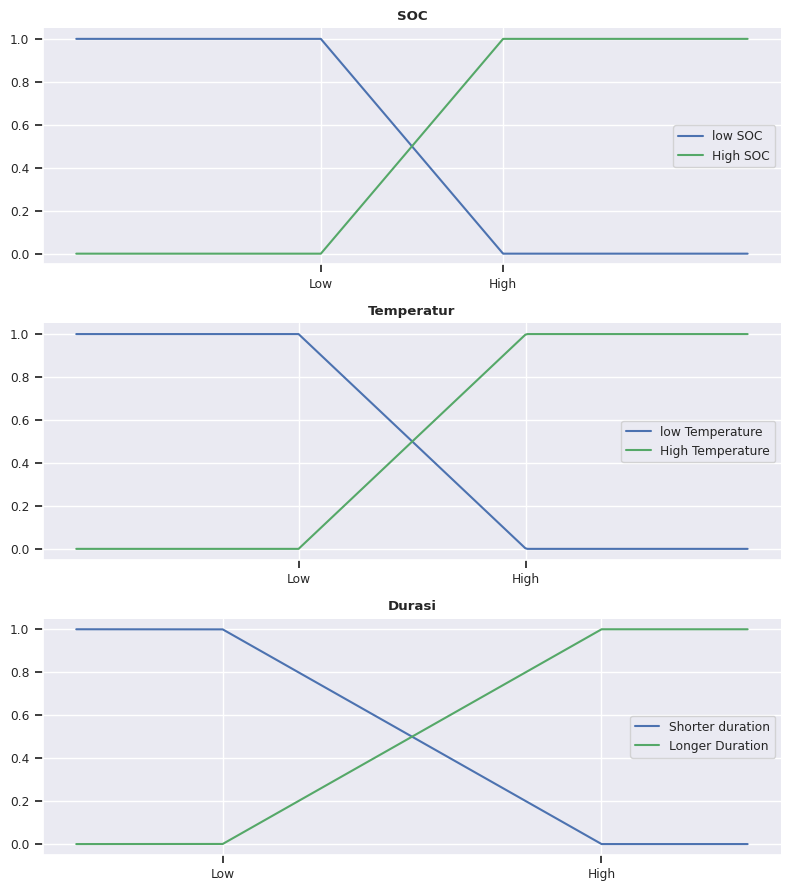

In [ ]:
# Create subplots for fuzzy membership function plots
fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, figsize=(8, 9))

# Plot the low and high SOC membership functions on the first subplot (ax0)
ax0.plot(soc, soc_low, 'b', linewidth=1.5, label='Low SOC')
ax0.plot(soc, soc_high, 'g', linewidth=1.5, label='High SOC')
ax0.set_title('State of Charge (SOC)', fontweight='bold')
ax0.legend()
ax0.set_xticks([low_soc, high_soc])
ax0.set_xticklabels(['Low', 'High'])

# Plot the low and high temperature membership functions on the second subplot (ax1)
ax1.plot(tempt, tempt_low, 'b', linewidth=1.5, label='Low Temperature')
ax1.plot(tempt, tempt_high, 'g', linewidth=1.5, label='High Temperature')
ax1.set_title('Temperature', fontweight='bold')
ax1.legend()
ax1.set_xticks([low_temp, high_temp])
ax1.set_xticklabels(['Low', 'High'])

# Plot the low and high duration membership functions on the third subplot (ax2)
ax2.plot(duration, duration_low, 'b', linewidth=1.5, label='Shorter Duration')
ax2.plot(duration, duration_high, 'g', linewidth=1.5, label='Longer Duration')
ax2.set_title('Duration', fontweight='bold')
ax2.legend()
ax2.set_xticks([low_dur, high_dur])
ax2.set_xticklabels(['Low', 'High'])

# Remove top and right spines from all subplots for better appearance
for ax in (ax0, ax1, ax2):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()

# Adjust subplot layout for a better fit
plt.tight_layout()

In [ ]:
# Calculate the membership degrees for SOC based on the high SOC value
member_soc = [
    fuzz.interp_membership(soc, soc_low, high_soc - 0.01),  # Membership degree for low SOC
    fuzz.interp_membership(soc, soc_high, high_soc - 0.01)  # Membership degree for high SOC
]

# Calculate the membership degrees for temperature based on the low temperature value
member_temp = [
    fuzz.interp_membership(tempt, tempt_low, low_temp),    # Membership degree for low temperature
    fuzz.interp_membership(tempt, tempt_high, low_temp)    # Membership degree for high temperature
]

# Print the membership degrees for SOC and temperature
print('-' * 40, "\nMembership Degrees for SOC\n", '-' * 40)
print(f"Low SOC Membership\t: {member_soc[0]}\nHigh SOC Membership\t: {member_soc[1]}\n")

print('-' * 40, "\nMembership Degrees for Temperature\n", '-' * 40)
print(f"Low Temperature Membership\t: {member_temp[0]}\nHigh Temperature Membership\t: {member_temp[1]}\n")

---------------------------------------- 
Derajat Keanggotaan SOC
 ----------------------------------------
Low SOC 	: 0.16775482172128173
High SOC	: 0.8322451782787182

---------------------------------------- 
Derajat Keanggotaan Temperatur
 ----------------------------------------
Low Temperatur	: 0.9999999999991109
High Temperatur	: 8.890980631073219e-13



In [ ]:
# Calculate 'apred1' as the minimum of the membership degrees for high SOC and high temperature
# Calculate 'z1' as the weighted average of 'duration_diff' based on 'apred1' and 'low_dur'
apred1 = np.fmin(member_soc[1], member_temp[1])
z1 = (apred1 * duration_diff) + low_dur
print("Increasing, Value of apred1 = ", apred1)
print("Value of z1 = ", z1)

# Calculate 'apred2' as the minimum of the membership degrees for low SOC and low temperature
# Calculate 'z2' as the weighted average of 'duration_diff' based on 'apred2' and 'high_dur'
apred2 = np.fmin(member_soc[0], member_temp[0])
z2 = high_dur - (apred2 * duration_diff)
print("Decreasing, Value of apred2 = ", apred2)
print("Value of z2 = ", z2)

# Calculate 'apred3' as the minimum of the membership degrees for low SOC and high temperature
# Calculate 'z3' as the weighted average of 'duration_diff' based on 'apred3' and 'low_dur'
apred3 = np.fmin(member_soc[0], member_temp[1])
z3 = (apred3 * duration_diff) + low_dur
print("Increasing, Value of apred3 = ", apred3)
print("Value of z3 = ", z3)

# Calculate 'apred4' as the minimum of the membership degrees for high SOC and low temperature
# Calculate 'z4' as the weighted average of 'duration_diff' based on 'apred4' and 'low_dur'
apred4 = np.fmin(member_soc[1], member_temp[0])
z4 = (apred4 * duration_diff) + low_dur
print("Increasing, Value of apred4 = ", apred4)
print("Value of z4 = ", z4)

# Calculate the aggregated value 'z' as the weighted average of 'z1', 'z2', 'z3', and 'z4' based on their respective 'apred' values
z = (apred1 * z1 + apred2 * z2 + apred3 * z3 + apred4 * z4) / (apred1 + apred2 + apred3 + apred4)

Bertambah, Nilai apred1 =  8.890980631073219e-13
Nilai z1 =  1660.9463302561364
Berkurang, Nilai apred2 =  0.16775482172128173
Nilai z2 =  2038.1866025717059
Bertambah, Nilai apred3 =  8.890980631073219e-13
Nilai z3 =  1660.9463302561364
Bertambah, Nilai apred4 =  0.8322451782787182
Nilai z4 =  2038.1866025717059


In [ ]:
# Calculate the differences between t2, t3, and t4 values for the "high_soc" case
selisih_t2_t1 = result_summary.loc["high_soc"]["t2"] - result_summary.loc["high_soc"]["t1"]
selisih_t3_t2 = result_summary.loc["high_soc"]["t3"] - result_summary.loc["high_soc"]["t2"]
selisih_t4_t3 = result_summary.loc["high_soc"]["t4"] - result_summary.loc["high_soc"]["t3"]

# Calculate the final values of t1, t2, t3, and t4 based on a cutback factor
t1_final = result_summary.loc["high_soc"]["t1"] * cutback
t2_final = ((np.abs(result_summary.loc["high_soc"]["t1"] - t1_final) + selisih_t2_t1) * cutback) + result_summary.loc["high_soc"]["t2"]
t3_final = ((np.abs(result_summary.loc["high_soc"]["t2"] - t2_final) + selisih_t3_t2) * cutback) + result_summary.loc["high_soc"]["t3"]
t4_final = ((np.abs(result_summary.loc["high_soc"]["t3"] - t3_final) + selisih_t4_t3) * cutback) + result_summary.loc["high_soc"]["t4"]

# Return the final values of t1, t2, t3, and t4
t1_final, t2_final, t3_final, t4_final

(2114.1259532464446, 2536.4614340328953, 2542.264135810658, 3036.519734366466)

# **System to Generate Parameter**

In [ ]:
# Load the pre-trained model from the specified file path
model_path = '/content/drive/MyDrive/Tugas Akhir/model_ta.h5'
model = load_model(model_path)
model.summary()

In [ ]:
# Define a function to generate findings based on a machine learning model
def generate_finding(data, model, scalar):
    # Extract minimum values of t1, t2, t3, and t4 from the input data
    t1_check, t2_check, t3_check, t4_check = [data[data[col] == data[col].min()][col].values[0] for col in ["t1", "t2", "t3", "t4"]]

    # Input current environmental temperature and initial battery surface temperature
    suhu_ruangan = float(input("Current Environmental Temperature?\n"))
    suhu_awal_baterai = float(input("Current Battery Surface Temperature?\n"))

    params = []
    columns_name = ["t1", "t2", "t3", "t4"]

    # Generate random values for t1, t2, t3, and t4 until a certain condition is met
    while len(params) != 100000:
        t1 = random.random() * (2580 - 0)
        t2 = t1 + random.random() * (2580 - t1)
        t3 = t2 + random.random() * (2580 - t2)
        t4 = t3 + random.random() * (2580 - t3)

        # Check if generated values meet certain conditions
        if t1 >= t1_check and t2 >= t2_check and t3 >= t3_check and t4 >= t4_check and t1 <= (2580 / 1.5):
            params.append([t1, t2, t3, t4])

    # Create a DataFrame to store findings with environmental and battery temperature
    finding = pd.DataFrame({
        'suhuRuangan': [suhu_ruangan] * 100000,
        'suhuAwalBaterai': [suhu_awal_baterai] * 100000
    })

    # Concatenate generated parameters with the finding DataFrame
    finding = pd.concat([finding, pd.DataFrame(params, columns=columns_name)], axis=1)

    # Initialize columns for target variables (lastSOC and lastSuhu)
    for target in ["lastSOC", "lastSuhu"]:
        finding[target] = 0

    # Normalize the finding data using the provided scalar
    norm_finding = scalar.transform(np.array(finding))
    norm_finding_df = pd.DataFrame(norm_finding, columns=finding.columns)

    # Prepare input data (x_find) for model prediction and predict target variables (y_find)
    x_find = norm_finding_df.iloc[:, :-2]
    y_find = model.predict(x_find)

    # Inverse transform the normalized results to obtain actual values
    norm_result = pd.DataFrame(data=np.concatenate((x_find.values, y_find), axis=1),
                              columns=list(x_find.columns) + ["soc", "temp"])

    result = pd.DataFrame(scaler.inverse_transform(norm_result), columns=norm_result.columns)

    return result

In [ ]:
# Define a function to calculate 'z' using fuzzy logic for a specific step
def get_fuzzy(step, result_summary):
    durr_step = f"t{step}"

    # Extract relevant values from the result summary
    low_soc = result_summary.loc["min_temp"]["soc"]
    high_soc = result_summary.loc["high_soc"]["soc"]
    low_temp = result_summary.loc["min_temp"]["temp"]
    high_temp = result_summary.loc["high_soc"]["temp"]

    # Determine the lower and upper durations based on the selected step
    low_dur = result_summary.loc["min_temp"][durr_step] if result_summary.loc["min_temp"][durr_step] < result_summary.loc["high_soc"][durr_step] else result_summary.loc["high_soc"][durr_step]
    high_dur = result_summary.loc["high_soc"][durr_step] if result_summary.loc["min_temp"][durr_step] < result_summary.loc["high_soc"][durr_step] else result_summary.loc["min_temp"][durr_step]

    # Calculate the duration difference
    duration_diff = high_dur - low_dur

    # Define ranges for SOC, temperature, and duration
    soc = np.arange(low_soc - 0.08, high_soc + 0.08, 0.0001)
    tempt = np.arange(low_temp - 1, high_temp + 1, 0.01)
    duration = np.arange(low_dur - 175, high_dur + 175, 0.01)

    # Define fuzzy sets for SOC, temperature, and duration
    soc_low = fuzz.trapmf(soc, [0, 0, low_soc, high_soc])
    soc_high = fuzz.trapmf(soc, [low_soc, high_soc, 1, 1])
    tempt_low = fuzz.trapmf(tempt, [0, 0, low_temp, high_temp])
    tempt_high = fuzz.trapmf(tempt, [low_temp, high_temp, 330, 330])
    duration_low = fuzz.trapmf(duration, [0, 0, low_dur, high_dur])
    duration_high = fuzz.trapmf(duration, [low_dur, high_dur, 2800, 2800])

    # Calculate membership degrees for SOC and temperature
    member_soc = [fuzz.interp_membership(soc, soc_low, (high_soc + low_soc) / 2),
                  fuzz.interp_membership(soc, soc_high, (high_soc + low_soc) / 2)]
    member_temp = [fuzz.interp_membership(tempt, tempt_low, (high_temp + low_temp) / 2),
                  fuzz.interp_membership(tempt, tempt_high, (high_temp + low_temp) / 2)]

    # Calculate 'apred' values using fuzzy logic rules
    apred1 = np.fmin(member_soc[1], member_temp[1])
    z1 = (apred1 * duration_diff) + low_dur

    apred2 = np.fmin(member_soc[0], member_temp[0])
    z2 = high_dur - (apred2 * duration_diff)

    apred3 = np.fmin(member_soc[0], member_temp[1])
    z3 = (apred3 * duration_diff) + low_dur

    apred4 = np.fmin(member_soc[1], member_temp[0])
    z4 = (apred4 * duration_diff) + low_dur

    # Calculate the aggregated value 'z' as a weighted average
    z = (apred1 * z1 + apred2 * z2 + apred3 * z3 + apred4 * z4) / (apred1 + apred2 + apred3 + apred4)

    # Return the calculated 'z' value
    if durr_step == "t1":
        return z
    else:
        return z

In [ ]:
# Define lists of environmental temperatures and initial battery surface temperatures
list_suhu_ruangan = [301.15, 303.15, 305.15]
list_suhu_awal_baterai = [301.15, 303.15, 305.15]

# Initialize an empty DataFrame to store result summaries
result_summarys = pd.DataFrame()

# Iterate through environmental and initial battery surface temperatures
for ruang in list_suhu_ruangan:
    for baterai in list_suhu_awal_baterai:
        z_t = []  # Initialize a list to store 'z' values for each step

        # Set current environmental and initial battery surface temperatures
        suhu_ruangan = ruang
        suhu_awal_baterai = baterai

        # Generate the initial result summary for step 0 and calculate 'z_t1'
        result_summary = generate_finding(data, model, scaler, suhu_ruangan, suhu_awal_baterai, 0, z_t)
        z_t.append(get_fuzzy(1, result_summary))
        print(f"z_t{1} is Done")

        # Generate result summaries for steps 2 and 3 and calculate 'z_t2' and 'z_t3'
        for i in range(2):
            result_summary_nd = generate_finding(data, model, scaler, suhu_ruangan, suhu_awal_baterai, i, z_t)
            z_t.append(get_fuzzy(i+2, result_summary_nd))
            print(f"z_t{i+2} is Done")
            print(z_t)

        # Extract 'z_t1', 'z_t2', and 'z_t3' from the list 'z_t'
        z_t1, z_t2, z_t3 = z_t

        # Add a 'fuzzy' row to the result summary with relevant values
        result_summary.loc["fuzzy"] = [suhu_ruangan,
                                       suhu_awal_baterai,
                                       z_t1,
                                       z_t2,
                                       z_t3,
                                       z_t3 + random.random() * (2580 - z_t3),
                                       (result_summary.loc["high_soc"]["soc"] + result_summary.loc["min_temp"]["soc"]) / 2,
                                       (result_summary.loc["high_soc"]["temp"] + result_summary.loc["min_temp"]["temp"]) / 2]

        # Append the result summary to the DataFrame
        result_summarys = result_summarys.append(result_summary)
        print(f"Suhu awal Baterai : {baterai}, Suhu Ruangan : {ruang} is Done")


result_summarys.reset_index().rename(columns={'index': 'variabel'}).head() # Reset the index and rename columns in the result summary DataFrame
result_summarys_new = result_summarys.reset_index().rename(columns={'index': 'variabel'}) # Create a new DataFrame to store the modified result summaries

# Modify the 'soc' and 'temp' columns for rows where 'variabel' is not equal to "asd"
result_summarys_new.loc[result_summarys_new.variabel != "asd", 'soc'] -= 0.025
result_summarys_new.loc[result_summarys_new.variabel != "asd", 'temp'] -= 1

result_summarys_new.to_csv("result_predict.csv")

# **Result**

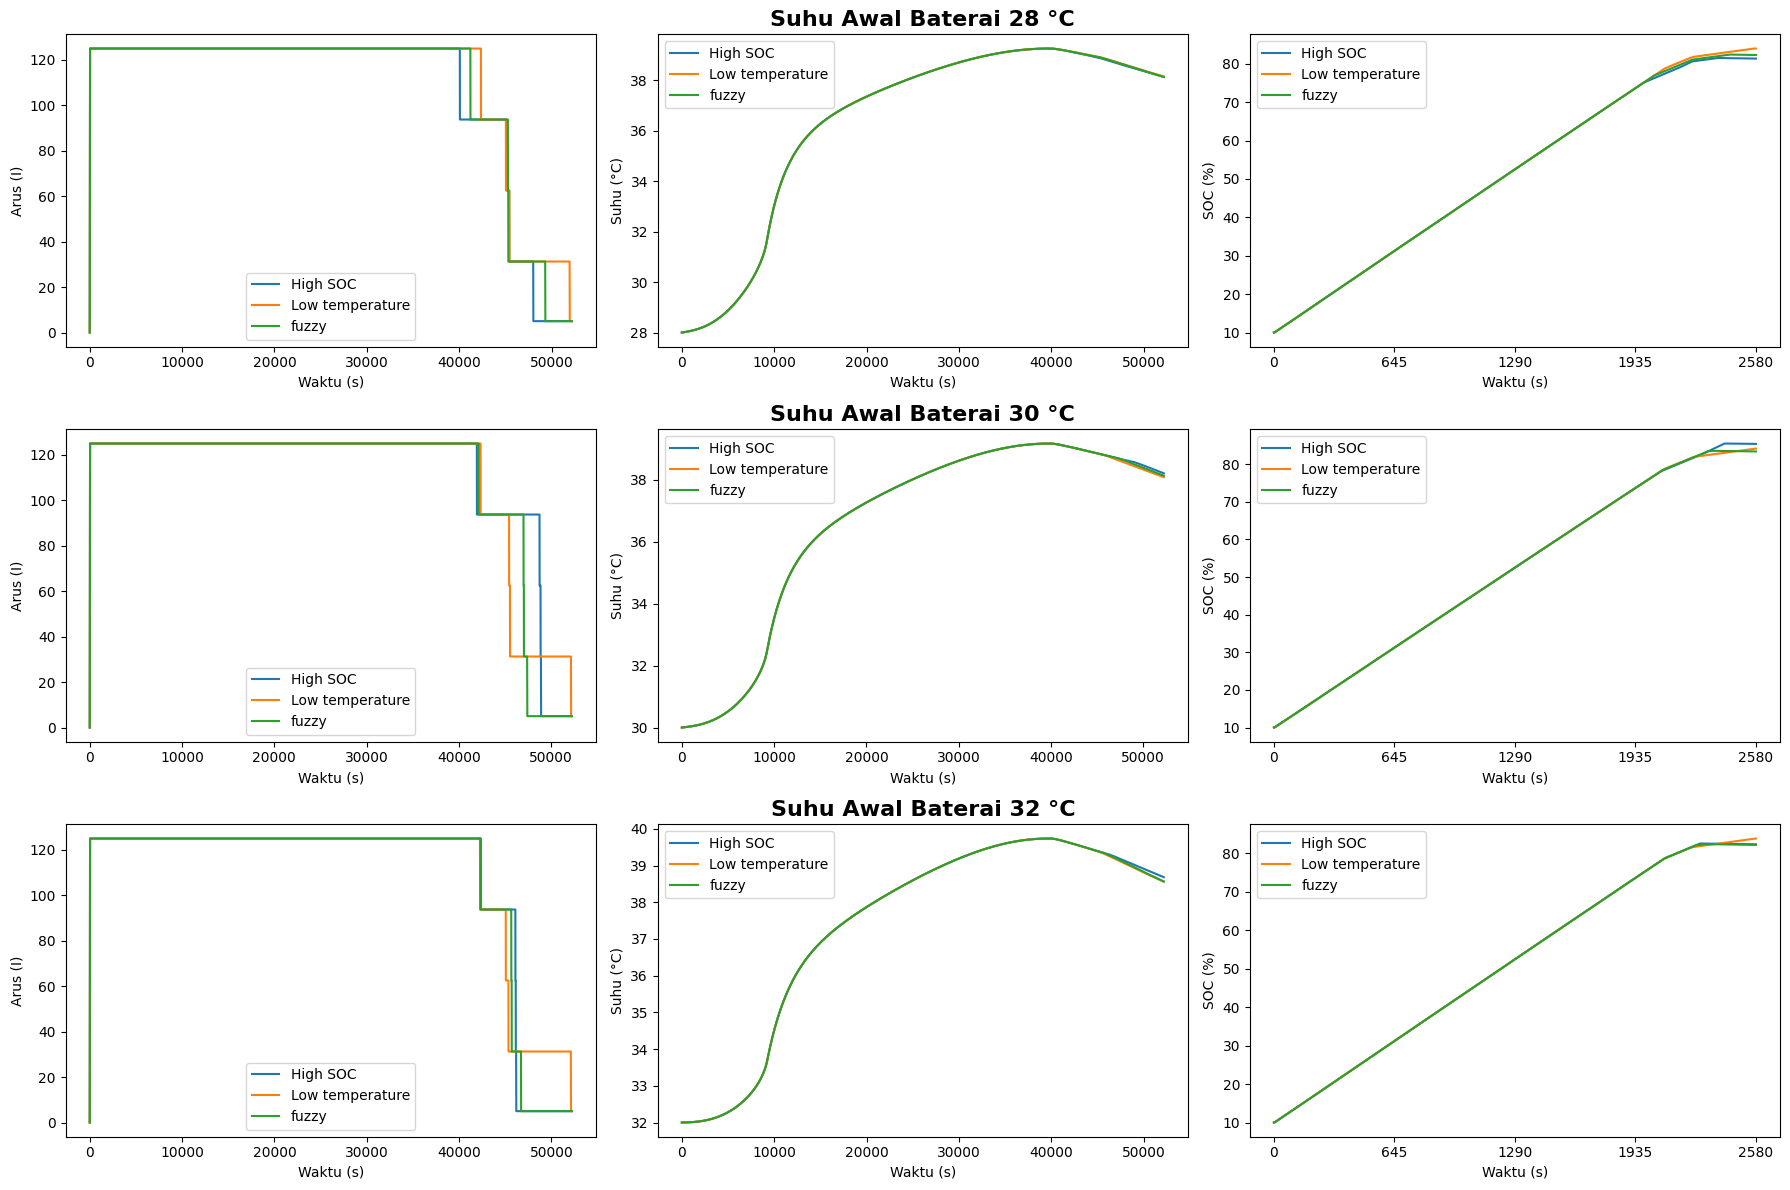

In [ ]:
# Define the names of sheets to be displayed
sheet_names = ['Sheet1', 'Sheet2', 'Sheet3']

# Define the initial battery temperatures to be displayed
initial_temperatures = [28, 30, 32]

# Create a 3x9 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(18, 12))

# Iterate through sheet names and corresponding initial temperatures
for i, sheet_name in enumerate(sheet_names):
    # Read the Excel file
    file_path = f"/content/drive/MyDrive/Tugas Akhir/timeseries_result/305.xlsx"
    result_grafik = pd.read_excel(file_path, sheet_name=sheet_name)
    result_grafik.dropna(inplace=True)

    # Scale columns by multiplying with 100 for 'high_soc', 'low_soc', and 'fuzz_soc'
    for j, column in enumerate(['high_soc', 'low_soc', 'fuzz_soc']):
        result_grafik[column] = result_grafik[column].apply(lambda x: x * 100)

    # Convert temperature columns from Kelvin to Celsius
    result_grafik[['high_temp', 'low_temp', 'fuzz_temp']] -= 273.15

    # Plot current column
    result_grafik[['high_i', 'low_i', 'fuzz_i']].plot(ax=axs[i, 0])
    axs[i, 0].set_title('Current', fontweight='bold')
    axs[i, 0].set_xlabel('Time (s)')
    axs[i, 0].set_ylabel('Current (I)')

    # Plot temperature column
    result_grafik[['high_temp', 'low_temp', 'fuzz_temp']].plot(ax=axs[i, 1])
    axs[i, 1].set_title('Temperature', fontweight='bold')
    axs[i, 1].set_xlabel('Time (s)')
    axs[i, 1].set_ylabel('Temperature (°C)')

    # Plot SOC column
    result_grafik[['high_soc', 'low_soc', 'fuzz_soc']].plot(ax=axs[i, 2])
    axs[i, 2].set_title('SOC', fontweight='bold')
    axs[i, 2].set_xlabel('Time (s)')
    axs[i, 2].set_ylabel('SOC (%)')

    # Configure x-axis ticks and labels
    x_ticks = np.linspace(0, len(result_grafik), 5, dtype=int)
    x_labels = np.linspace(0, 2580, 5, dtype=int)
    axs[i, 2].set_xticks(x_ticks)
    axs[i, 2].set_xticklabels(x_labels)

    # Set legends and titles for each plot
    axs[i, 0].legend(['High SOC', 'Low temperature', 'Fuzzy'])
    axs[i, 1].legend(['High SOC', 'Low temperature', 'Fuzzy'])
    axs[i, 2].legend(['High SOC', 'Low temperature', 'Fuzzy'])
    axs[i, 0].set_title("", fontweight='bold')
    axs[i, 2].set_title("", fontweight='bold')
    axs[i, 1].set_title(f"Initial Battery Temperature {initial_temperatures[i]} °C", fontweight='bold', fontsize=16)

# Display the grid of plots
plt.tight_layout()
plt.show()